In [5]:
import os
import pandas as pd
def data_dictionary():
    path_train="dataset/"
    list_train=os.listdir(path_train)
    train_dictionary={"image_path":[],"target":[]}
    k=0
    for i in list_train:
        path_disease_train=path_train+i
        image_list_train=os.listdir(path_disease_train)
        for j in image_list_train:
            img_path_train=path_disease_train+"/"+j   
            train_dictionary["image_path"].append(img_path_train)
            train_dictionary['target'].append(k)     
        k+=1
    train_df=pd.DataFrame(train_dictionary)
    return  train_df

In [6]:
data=data_dictionary()

In [7]:
data

,image_path,target
0,dataset/Tinea Ringworm Candidiasis and other F...,0
1,dataset/Tinea Ringworm Candidiasis and other F...,0
2,dataset/Tinea Ringworm Candidiasis and other F...,0
3,dataset/Tinea Ringworm Candidiasis and other F...,0
4,dataset/Tinea Ringworm Candidiasis and other F...,0
...,...,...
23179,dataset/Exanthems and Drug Eruptions/nosiedrug...,22
23180,dataset/Exanthems and Drug Eruptions/nosie1dru...,22
23181,dataset/Exanthems and Drug Eruptions/nosie5dru...,22
23182,dataset/Exanthems and Drug Eruptions/rotation3...,22


In [8]:
lable=data['target']

In [9]:
import cv2
images=[]
label=[]
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
for i in data['image_path']:
    img = load_img(i, target_size=(100, 100))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    images.append(x) 

2023-07-18 15:02:58.557505: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-18 15:02:58.651783: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-18 15:02:58.652882: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 15:03:00.268994: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
import numpy as np
import pandas as pd
dataset=np.array(images)


In [11]:
dataset.shape

(23184, 1, 100, 100, 3)

In [12]:
dataset = np.reshape(dataset, (23184, 100, 100, 3))

In [13]:
lable=np.array(lable)

In [14]:
lable.shape

(23184,)

In [3]:
import gc
# Delete variables from memory

#del images

In [4]:
gc.collect()

949

In [15]:
vgg_model = VGG19(weights = 'imagenet',  include_top = False, input_shape = (100,100 ,3))                                                                            

80134624/80134624 [==============================] - 0s 0us/step


In [16]:
# let's make all layers non-trainable
for layer in vgg_model.layers : 
    layer.trainable = False
    

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten, Dense


In [18]:
model=Sequential([ 
                   
                    Dense(200,activation='relu'),
                  Dense(170,activation='relu'),
                  Dense(23,activation='softmax'),

])

In [19]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [20]:
mcp_save = ModelCheckpoint('EnetB0_CIFAR10_TL.h5', save_best_only=True, monitor='val_acc')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1,)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split 

In [22]:
import keras
acc=[]
num_classes = 23
lable = keras.utils.to_categorical(lable, num_classes)

In [23]:
lable.shape



(23184, 23)

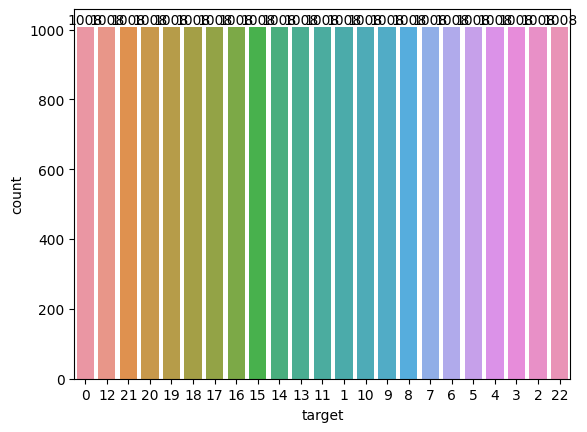

In [25]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
from PIL import Image
ax = sns.countplot(x=data['target'],
                   order=data['target'].value_counts(ascending=False).index);
abs_values = data['target'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values);

Found 23184 images belonging to 23 classes.


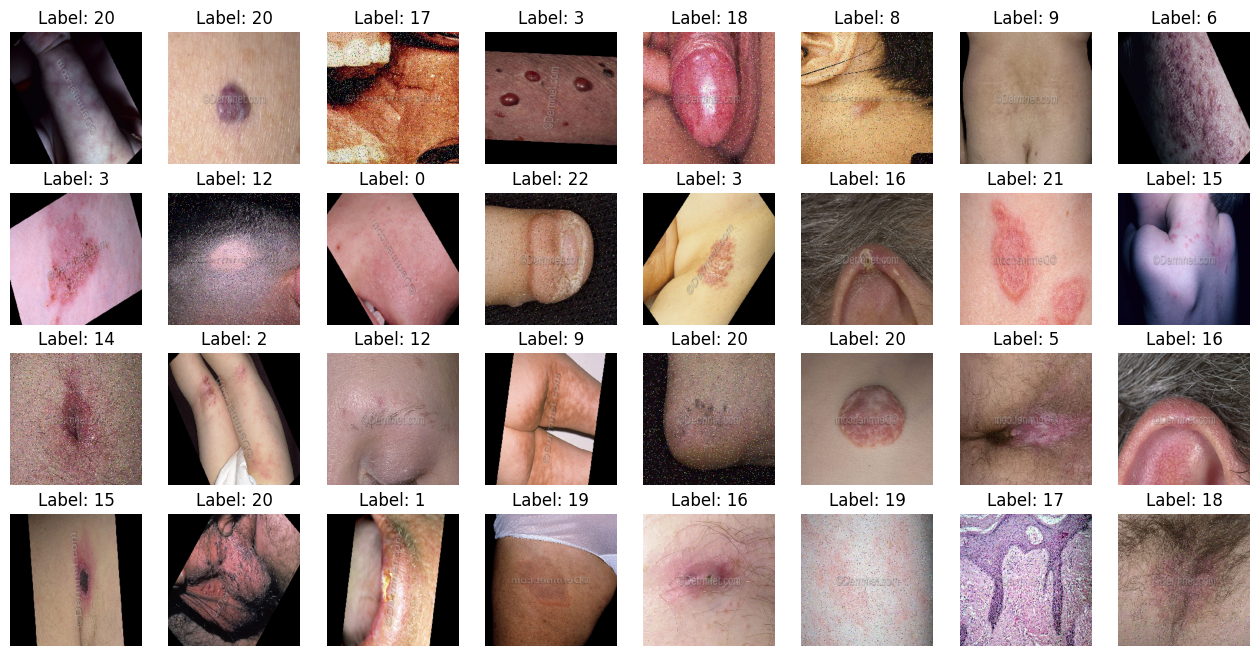

In [27]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data generator
datagen = ImageDataGenerator(rescale=1./255)

# Generate a batch of images and labels
batch_size = 32
train_generator = datagen.flow_from_directory(
    'dataset',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

images, labels = next(train_generator)

# Plot the images
fig, ax = plt.subplots(4, 8, figsize=(16, 8))
for i in range(4):
    for j in range(8):
        ax[i, j].imshow(images[i*8+j])
        ax[i, j].axis('off')
        ax[i, j].set_title('Label: {}'.format(labels[i*8+j].argmax()))
plt.show()

In [24]:

for i in range(3): 
    x_train,x_test, y_train, y_test=train_test_split(dataset, lable, test_size=0.2,random_state = np.random.randint(1,1000, 1)[0])
    # let's make all layers non-trainable
    for layer in vgg_model.layers :
        layer.trainable = False
    features_train=vgg_model.predict(x_train)
    features_test=vgg_model.predict(x_test)
    #features_train.shape
    num_train=x_train.shape[0]
    num_test=x_test.shape[0]
    x_test=features_test.reshape(num_test,-1)
    x_train=features_train.reshape(num_train,-1)
    #x_train,x_valid,y_train,y_valid= train_test_split(x_train, y_train, test_size=0.1,random_state = np.random.randint(1,1000, 1)[0]) 
    history=model.fit(x_train,y_train,epochs=15,batch_size=32,verbose=1) 
    model.evaluate(x_test,y_test)

2023-07-18 15:06:57.026833: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2225640000 exceeds 10% of free system memory.


145/145 [==============================] - 152s 1s/step
Epoch 1/15
580/580 [==============================] - 5s 7ms/step - loss: 2.2621 - accuracy: 0.4259
Epoch 2/15
580/580 [==============================] - 4s 7ms/step - loss: 0.8794 - accuracy: 0.7397
Epoch 3/15
580/580 [==============================] - 4s 7ms/step - loss: 0.4811 - accuracy: 0.8535
Epoch 4/15
580/580 [==============================] - 4s 7ms/step - loss: 0.3416 - accuracy: 0.8970
Epoch 5/15
580/580 [==============================] - 4s 7ms/step - loss: 0.3545 - accuracy: 0.8938
Epoch 6/15
580/580 [==============================] - 4s 7ms/step - loss: 0.2394 - accuracy: 0.9280
Epoch 7/15
580/580 [==============================] - 4s 7ms/step - loss: 0.2148 - accuracy: 0.9367
Epoch 8/15
580/580 [==============================] - 4s 7ms/step - loss: 0.2604 - accuracy: 0.9303
Epoch 9/15
580/580 [==============================] - 5s 8ms/step - loss: 0.2185 - accuracy: 0.9392
Epoch 10/15
580/580 [=======================

2023-07-18 15:20:38.234023: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2225640000 exceeds 10% of free system memory.


145/145 [==============================] - 150s 1s/step
Epoch 1/15
580/580 [==============================] - 4s 7ms/step - loss: 0.2979 - accuracy: 0.9322
Epoch 2/15
580/580 [==============================] - 4s 7ms/step - loss: 0.1548 - accuracy: 0.9588
Epoch 3/15
580/580 [==============================] - 4s 7ms/step - loss: 0.1188 - accuracy: 0.9672
Epoch 4/15
580/580 [==============================] - 4s 7ms/step - loss: 0.1319 - accuracy: 0.9654
Epoch 5/15
580/580 [==============================] - 4s 7ms/step - loss: 0.1735 - accuracy: 0.9555
Epoch 6/15
580/580 [==============================] - 4s 7ms/step - loss: 0.1521 - accuracy: 0.9649
Epoch 7/15
580/580 [==============================] - 4s 7ms/step - loss: 0.1165 - accuracy: 0.9701
Epoch 8/15
580/580 [==============================] - 4s 7ms/step - loss: 0.1387 - accuracy: 0.9660
Epoch 9/15
580/580 [==============================] - 4s 7ms/step - loss: 0.1577 - accuracy: 0.9618
Epoch 10/15
580/580 [=======================

2023-07-18 15:34:20.715188: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2225640000 exceeds 10% of free system memory.


145/145 [==============================] - 149s 1s/step
Epoch 1/15
580/580 [==============================] - 4s 7ms/step - loss: 0.2165 - accuracy: 0.9599
Epoch 2/15
580/580 [==============================] - 4s 6ms/step - loss: 0.1061 - accuracy: 0.9749
Epoch 3/15
580/580 [==============================] - 4s 6ms/step - loss: 0.1039 - accuracy: 0.9748
Epoch 4/15
580/580 [==============================] - 4s 7ms/step - loss: 0.1368 - accuracy: 0.9701
Epoch 5/15
580/580 [==============================] - 4s 6ms/step - loss: 0.1118 - accuracy: 0.9745
Epoch 6/15
580/580 [==============================] - 4s 6ms/step - loss: 0.0967 - accuracy: 0.9775
Epoch 7/15
580/580 [==============================] - 4s 6ms/step - loss: 0.1405 - accuracy: 0.9723
Epoch 8/15
580/580 [==============================] - 4s 6ms/step - loss: 0.1002 - accuracy: 0.9775
Epoch 9/15
580/580 [==============================] - 4s 7ms/step - loss: 0.0824 - accuracy: 0.9793
Epoch 10/15
580/580 [=======================

In [28]:
h=history.history
h.keys()

dict_keys(['loss', 'accuracy'])

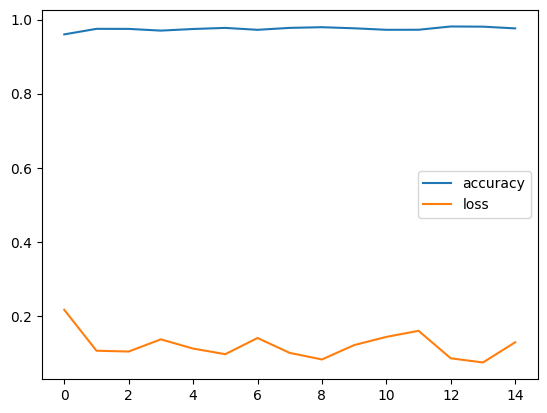

In [29]:
plt.plot(h['accuracy'])


plt.plot(h['loss'])




plt.legend(['accuracy','loss'])
plt.show()

In [31]:
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
y_pred

145/145 [==============================] - 0s 2ms/step


array([ 1,  9, 12, ..., 19,  4, 15])

In [32]:
y_test=np.argmax(y_test, axis=1)

In [33]:
y_test

array([ 1,  9, 12, ..., 19,  4, 21])

In [52]:
from sklearn.metrics import *
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       204
           1       1.00      0.95      0.98       189
           2       0.98      0.95      0.96       223
           3       0.98      0.98      0.98       217
           4       0.95      0.96      0.96       193
           5       0.99      0.99      0.99       205
           6       0.96      0.97      0.97       195
           7       0.96      0.95      0.96       198
           8       0.95      1.00      0.98       205
           9       0.92      0.81      0.86       199
          10       0.83      0.93      0.88       209
          11       0.99      0.98      0.98       205
          12       0.99      0.95      0.97       209
          13       0.96      0.97      0.96       213
          14       0.99      0.99      0.99       195
          15       0.91      0.99      0.95       199
          16       0.97      0.96      0.97       197
          17       0.96    

In [115]:
y_pred_cus=model.predict(x_test[500:1000])
y_pred_cus=np.argmax(y_pred_cus, axis=1)

16/16 [==============================] - 0s 2ms/step


In [118]:
cm_csu = confusion_matrix(y_test[500:1000], y_pred_cus)
print(cm_csu)

[[19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 31  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 22  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 21  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0 17  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1 18  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0  0

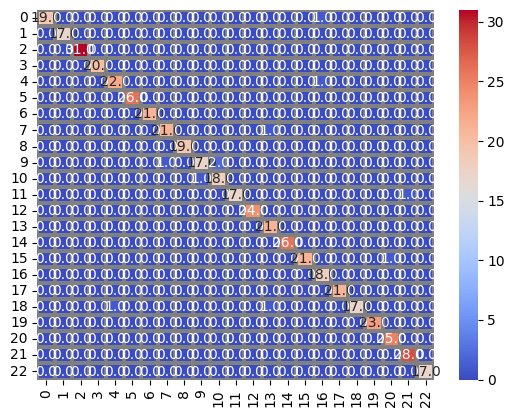

In [119]:
# Create a heatmap plot of the data with custom parameters
ax = sns.heatmap(cm_csu, cmap='coolwarm', annot=True, fmt='.1f', linewidths=1.5, linecolor='gray', cbar=True)

In [120]:

model.save('kfolds3-acc96%.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
